### Data handling in PyTorch with Dataset and Dataloader classes ###

In [1]:
import numpy as np
from matplotlib import pyplot as plt

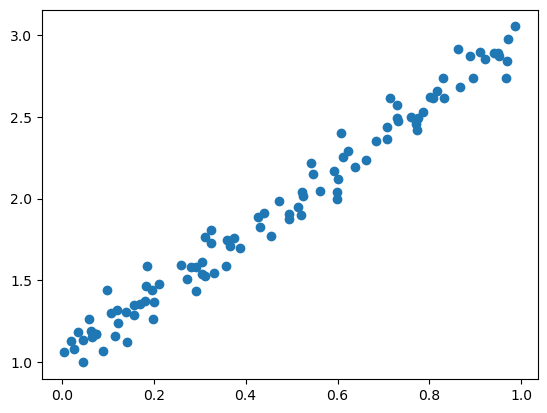

In [2]:
# Data Generation x and y

np.random.seed(42) # For reproducibility

x = np.random.rand(100, 1) # 100 random numbers between 0 and 1
y = 1 + 2 * x + .1 * np.random.randn(100, 1) # y = 1 + 2x + noise

plt.scatter(x,y) # Scatter plot of x and y
plt.show() # Show the plot

In [3]:
# import required modules to use pyTorch

import torch # PyTorch
import torch.optim as optim # Optimizer
import torch.nn as nn # Neural Network

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Send data and model to GPU or CPU

In [5]:
torch.manual_seed(42) # For reproducibility

In [13]:
# Create the Model Class

class LayerLinearRegression(nn.Module): # Inherit from nn.Module
    def __init__(self): # Constructor
        super().__init__() # Call the parent constructor
        self.linear = nn.Linear(1, 1) # Instead of custom parameters, we use Linear layer with single input and output
                
    def forward(self, x): # Forward pass
        x = self.linear(x) # Now it only takes a call to the layer to make predictions
        return x # Return the prediction

#### Dataset and reading in the dataset ####

In PyTorch, a dataset is represented by a regular Python class that inherits from the Dataset class.<br> 
When called, the Dataset class sends a Python tuple consisting of one datapoint (feature, lanel) ,<br><br>
The most fundamental methods it needs to implement are:

    __init__(self) : it takes whatever arguments needed to build a list of tuples — it may be the name of a CSV file that will be loaded and processed; it may be two tensors, one for features, another one for labels; or anything else, depending on the task at hand. 

There is no need to load the whole dataset in the constructor method (__init__). If your dataset is big (tens of thousands of image files, for instance), loading it at once would not be memory efficient. It is recommended to load them on demand (whenever __get_item__ is called):

    __get_item__(self, index): it allows the dataset to be indexed, so it can work like a list (dataset[i]) — it must return a tuple (features, label) corresponding to the requested data point. We can either return the corresponding slices of our pre-loaded dataset or tensors or, as mentioned above, load them on demand (like in this example).
    
    __len__(self): it should simply return the size of the whole dataset so, whenever it is sampled, its indexing is limited to the actual size.

In [6]:
# We use the PyTorch Dataset Class to construct a customized class for data retrieval
# It should return to us a single datapoint tuple as a torch tensor

from torch.utils.data import Dataset # Dataset class

class CustomDataset(Dataset): # Inherit from Dataset
    def __init__(self, x_tensor, y_tensor): # Constructor
        self.x = x_tensor # Store the data
        self.y = y_tensor # Store the data

    def __len__(self): # Length of the dataset
        return len(self.x) # Return the length of the data
    
    def __getitem__(self, index): # Get a single item
        x = self.x[index] # Get the x value
        y = self.y[index] # Get the y value
        return (torch.from_numpy(x).float(),torch.from_numpy(y).float()) # Return the data as torch tensor


In [12]:
# Let us test the methods in the above class to make sure it gives us what we need

# Instantiate an object of the dataset class
dataset = CustomDataset(x, y)

# Let us see if it provides us the length of the dataset
print(f"Length of the dataset is:{dataset.__len__()}")

# Let us see if it returns a single data point when called with an index number
print(f"\nThe data point tuple is:{dataset.__getitem__(0)}")

print('\n',"ITWORKS!!!")

Length of the dataset is:100

The data point tuple is:(tensor([0.3745]), tensor([1.7578]))

 ITWORKS!!!


In [7]:
# Import Dataloader 
from torch.utils.data import DataLoader # Dataloader
from sklearn.model_selection import train_test_split # Useful for large datasets

In [8]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2) # Split data into train and test

In [9]:
# Create train and test Dataset Class objects

train_dataset = CustomDataset(X_train,y_train) # Train dataset
test_dataset = CustomDataset(X_test,y_test) # Test dataset

# Use the PyTorch Dataloader function to dataset object in mini batch sizes
train_loader = DataLoader(dataset=train_dataset, batch_size=16) # Batch size of 16
test_loader = DataLoader(dataset=test_dataset, batch_size=20) # Batch size of 20

In [10]:
# Function defining a basic single Train step 

def make_train_step(model, loss_fn, optimizer): # Function that returns a function
    def train_step(x, y): # Builds function that performs a step in the train loop

        model.train() # Sets model to TRAIN mode
        yhat = model(x) # Makes predictions
        loss = loss_fn(y, yhat) # Computes loss
        loss.backward() # Computes gradients
        optimizer.step() # Updates parameters
        optimizer.zero_grad() # Zero the gradients
        return loss.item() # Returns the loss
    
    return train_step # Returns the function that will be called inside the train loop

In [14]:
# Now we can create a object of the model and send it at once to the device
# Make this a standard practice even if using only CPU

model = LayerLinearRegression().to(device) # Send model to device CPU or GPU
print(f"Initial parameters w0 and w1:\n{model.state_dict()}") # We can also inspect its parameters using its state_dict

# Initialize learning rate and number of epochs
lr = 1e-1 # Learning rate
n_epochs = 1000 # Number of epochs

# Instantiate the loss function objectthe optimizer
loss_fn = nn.MSELoss(reduction='mean') # Loss function

# Instantiate the optimizer by feed it the parameters to be optimized and the learning rate
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer

Initial parameters w0 and w1:
OrderedDict([('linear.weight', tensor([[0.7645]])), ('linear.bias', tensor([0.8300]))])


In [15]:
# Start the model training process by calling the training function n-epochs number of times
# Create containers for holding the parameters we need for plotting
# Include evaluation requirements

losses = [] # Training losses
val_losses = [] # Validation losses

train_step = make_train_step(model, loss_fn, optimizer) # Create the train step function

for epoch in range(n_epochs): # Loop over the dataset multiple times
    for x_batch, y_batch in train_loader: # Loop over the mini-batches
        x_batch = x_batch.to(device) # Send data to device
        y_batch = y_batch.to(device) # Send data to device

        loss = train_step(x_batch, y_batch) # Perform a training step
        losses.append(loss) # Record the loss
        
    # Put the model in eval mode to output its predictions on the validation data
    # Notice we also tell the model that gradient descent is not required in this step
    with torch.no_grad(): # No gradient descent
        for x_val, y_val in test_loader: # Loop over the mini-batches
            x_val = x_val.to(device) # Send data to device
            y_val = y_val.to(device) # Send data to device
            
            model.eval() # Set model to EVAL mode

            yhat = model(x_val) # Make predictions
            val_loss = loss_fn(y_val, yhat) # Compute the loss
            val_losses.append(val_loss.item()) # Record the loss

parameters = model.state_dict() # Get the final parameters of the model
print(f" Final Model Parameters Values of w0 and w1:{model.state_dict()}") # Print the final parameters

 Final Model Parameters Values of w0 and w1:OrderedDict([('linear.weight', tensor([[1.9536]])), ('linear.bias', tensor([1.0057]))])


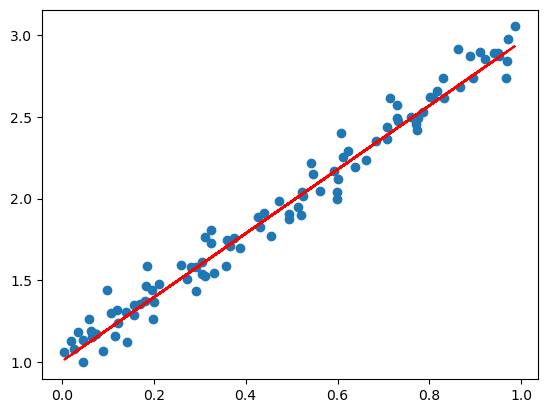

In [16]:
# Line of regression

plt.scatter(x,y) # Scatter plot of x and y
plt.plot(x,parameters['linear.bias'] + parameters['linear.weight']*x,c='r') # Regression line
plt.show() # Show the plot

In [17]:
print(f"Starting training loss:{losses[0]},\nEnding training loss:{losses[-1]}") # Print the starting and ending training losses

Starting training loss:0.7973276376724243,
Ending training loss:0.008481704629957676


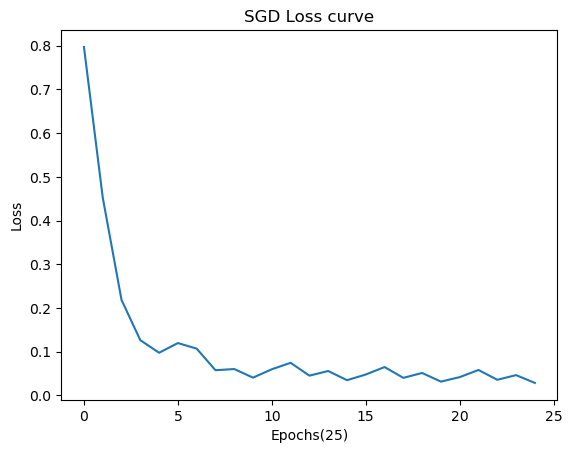

In [18]:
# Plot loss vs epochs - See how SGD performed

plt.plot(losses[:25]) # Plot the first 25 epochs
plt.xlabel('Epochs(25)') # Label x-axis
plt.ylabel('Loss') # Label y-axis
plt.title('SGD Loss curve') # Title
plt.show() # Show the plot